In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading the Dataset

In [3]:
BASE_DIR = "/kaggle/input/utkface-new/UTKFace"

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [6]:
df['gender'].value_counts()

gender
0    12391
1    11317
Name: count, dtype: int64

In [7]:
df['age'].nunique()

104

In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

### Exploratory Data Analysis

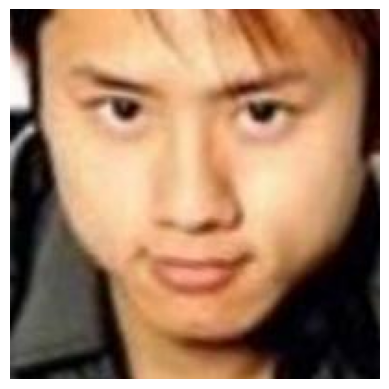

In [9]:
from PIL import Image

img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

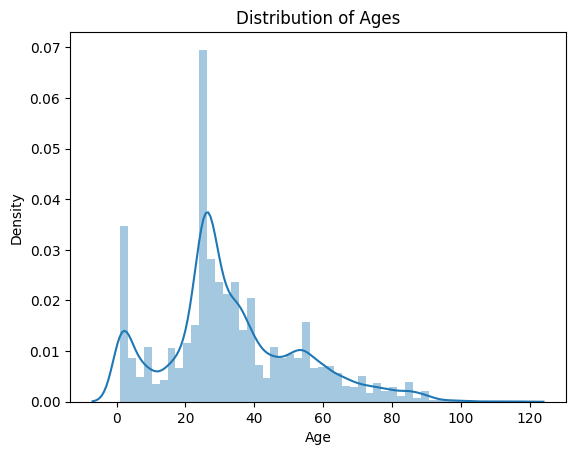

In [10]:
sns.distplot(df['age'])
plt.xlabel('Age')
plt.ylabel('Density')
plt.title("Distribution of Ages")
plt.show()

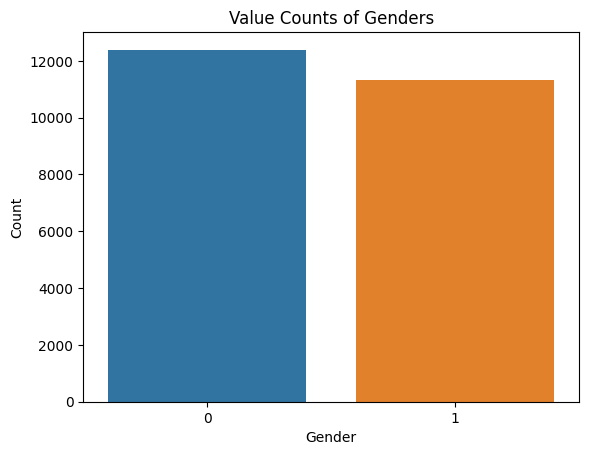

In [11]:
sns.countplot(x = 'gender', data = df)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Value Counts of Genders")
plt.show()

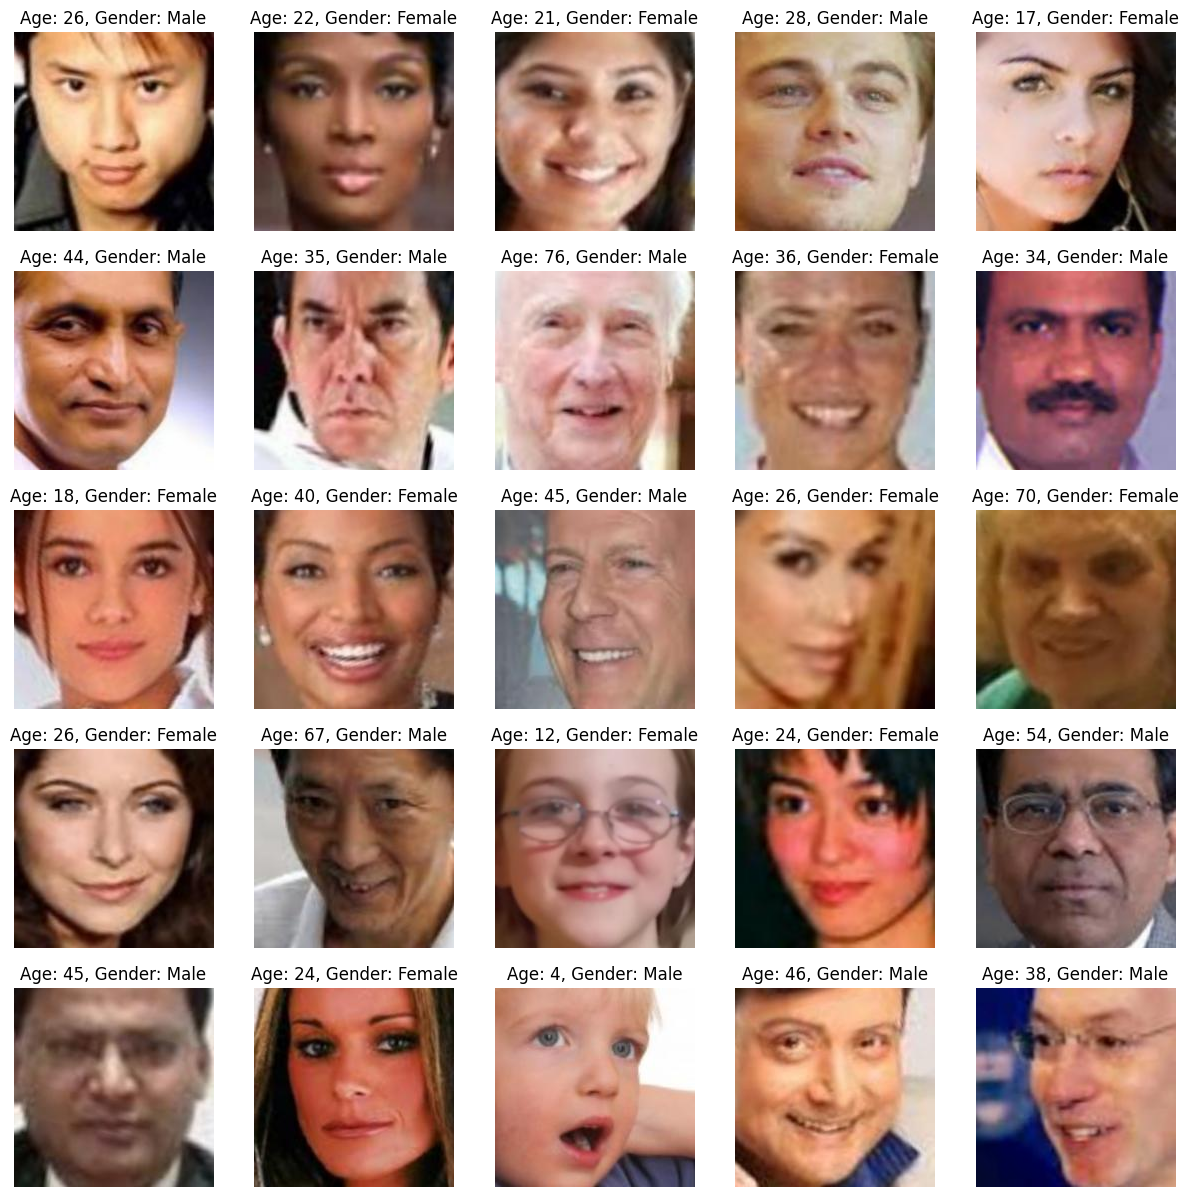

In [12]:
# to display grid of images
plt.figure(figsize=(15, 15))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}, Gender: {gender_dict[gender]}")
    plt.axis('off')

### Feature Extraction

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [15]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [16]:
type(X)

numpy.ndarray

The below code saves the above numpy ndarray locally. So to just load it we can run the below code.

In [18]:
#np.save('X.npy', X)
#X = np.load('X.npy')

In [19]:
X.shape

(23708, 128, 128, 1)

In [20]:
# normalize the images
X = X/255.0

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
print(y_gender.shape, y_age.shape)

(23708,) (23708,)


### Train test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(X, y_gender, y_age, test_size = 0.2, random_state = 1)

In [24]:
print(X_train.shape, X_test.shape)
print(y_train_gender.shape, y_test_gender.shape)
print(y_train_age.shape, y_test_age.shape)

(18966, 128, 128, 1) (4742, 128, 128, 1)
(18966,) (4742,)
(18966,) (4742,)


### Model Creation

In [25]:
input_shape = (128, 128, 1)

## Model for Gender Prediction

In [26]:
gender_model = Sequential()
gender_model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
gender_model.add(MaxPooling2D((2,2)))
gender_model.add(Conv2D(64, (3,3), activation='relu'))
gender_model.add(MaxPooling2D((2,2)))
gender_model.add(Conv2D(128, (3,3), activation='relu'))
gender_model.add(MaxPooling2D((2,2)))
gender_model.add(Flatten())
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])


### Model for Age prediction

In [27]:
age_model = Sequential()
age_model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
age_model.add(MaxPooling2D((2,2)))
age_model.add(Conv2D(64, (3,3), activation='relu'))
age_model.add(MaxPooling2D((2,2)))
age_model.add(Conv2D(128, (3,3), activation='relu'))
age_model.add(MaxPooling2D((2,2)))
age_model.add(Flatten())
age_model.add(Dense(64, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='relu'))

age_model.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))


In [28]:
# inputs = Input((input_shape))
# # convolutional layers
# conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
# maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
# conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
# maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
# conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
# maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
# conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
# maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

# flatten = Flatten() (maxp_4)

# # fully connected layers
# dense_1 = Dense(256, activation='relu') (flatten)
# dense_2 = Dense(256, activation='relu') (flatten)

# dropout_1 = Dropout(0.3) (dense_1)
# dropout_2 = Dropout(0.3) (dense_2)

# output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
# output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

# model = Model(inputs=[inputs], outputs=[output_1, output_2])

# model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

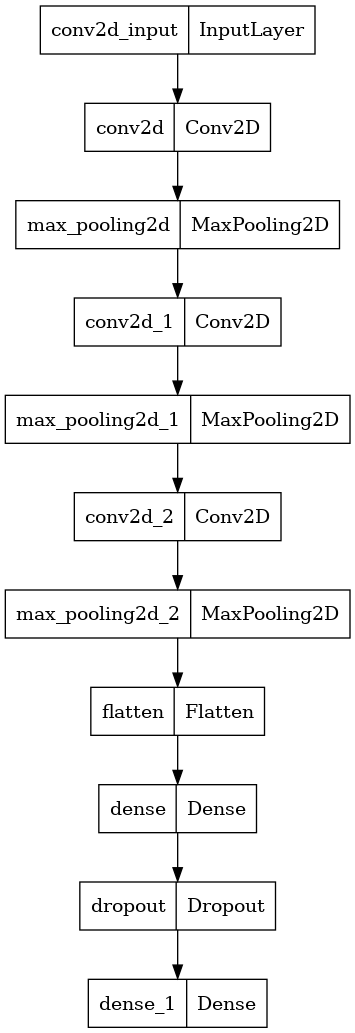

In [29]:
# plot the models
from tensorflow.keras.utils import plot_model
plot_model(gender_model)

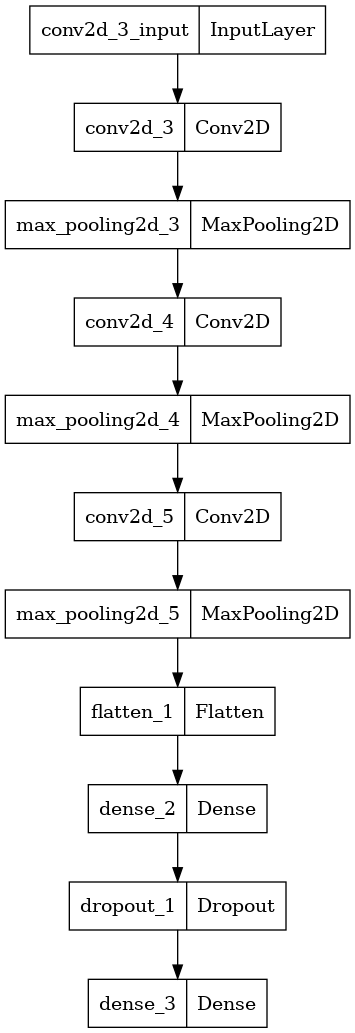

In [30]:
plot_model(age_model)

In [31]:
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [32]:
age_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [33]:
# train model
history_gender = gender_model.fit(x=X_train, y= y_train_gender, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
475/475 [==============================] - 21s 18ms/step - loss: 0.5430 - accuracy: 0.7249 - val_loss: 0.4082 - val_accuracy: 0.8110
Epoch 2/30
475/475 [==============================] - 7s 15ms/step - loss: 0.3833 - accuracy: 0.8338 - val_loss: 0.3480 - val_accuracy: 0.8437
Epoch 3/30
475/475 [==============================] - 7s 15ms/step - loss: 0.3445 - accuracy: 0.8469 - val_loss: 0.3414 - val_accuracy: 0.8461
Epoch 4/30
475/475 [==============================] - 7s 15ms/step - loss: 0.3234 - accuracy: 0.8596 - val_loss: 0.2983 - val_accuracy: 0.8653
Epoch 5/30
475/475 [==============================] - 7s 15ms/step - loss: 0.3099 - accuracy: 0.8669 - val_loss: 0.3034 - val_accuracy: 0.8622
Epoch 6/30
475/475 [==============================] - 7s 15ms/step - loss: 0.3001 - accuracy: 0.8690 - val_loss: 0.2798 - val_accuracy: 0.8769
Epoch 7/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2836 - accuracy: 0.8752 - val_loss: 0.2742 - val_accuracy: 0.876

In [34]:
#training for age_model
history_age = age_model.fit(x=X_train, y = y_train_age, batch_size = 32, epochs = 30, validation_split = 0.2)

Epoch 1/30
475/475 [==============================] - 8s 16ms/step - loss: 486.9641 - val_loss: 357.3200
Epoch 2/30
475/475 [==============================] - 7s 15ms/step - loss: 315.0134 - val_loss: 283.8632
Epoch 3/30
475/475 [==============================] - 7s 15ms/step - loss: 270.4377 - val_loss: 218.5103
Epoch 4/30
475/475 [==============================] - 7s 15ms/step - loss: 247.3784 - val_loss: 207.2970
Epoch 5/30
475/475 [==============================] - 7s 15ms/step - loss: 242.5840 - val_loss: 204.4878
Epoch 6/30
475/475 [==============================] - 7s 15ms/step - loss: 234.0484 - val_loss: 191.9893
Epoch 7/30
475/475 [==============================] - 7s 15ms/step - loss: 223.6697 - val_loss: 186.6937
Epoch 8/30
475/475 [==============================] - 7s 15ms/step - loss: 223.9373 - val_loss: 179.4590
Epoch 9/30
475/475 [==============================] - 7s 15ms/step - loss: 210.4459 - val_loss: 174.8084
Epoch 10/30
475/475 [==============================] - 

### Plotting the Results 

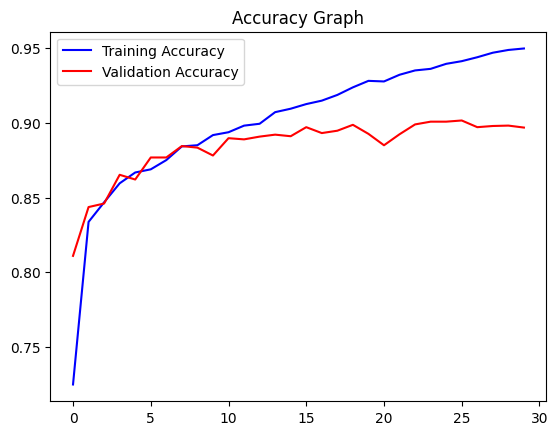

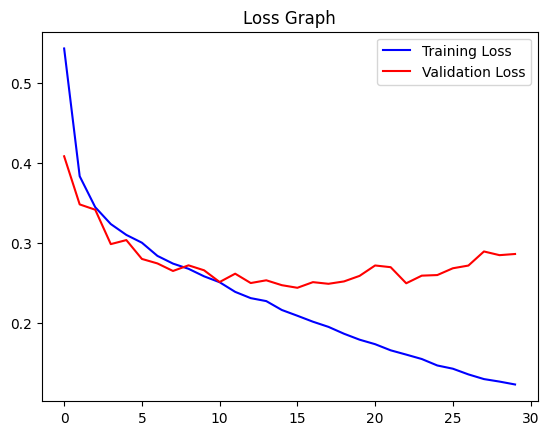

In [36]:
# plot results for gender
acc = history_gender.history['accuracy']
val_acc = history_gender.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history_gender.history['loss']
val_loss = history_gender.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

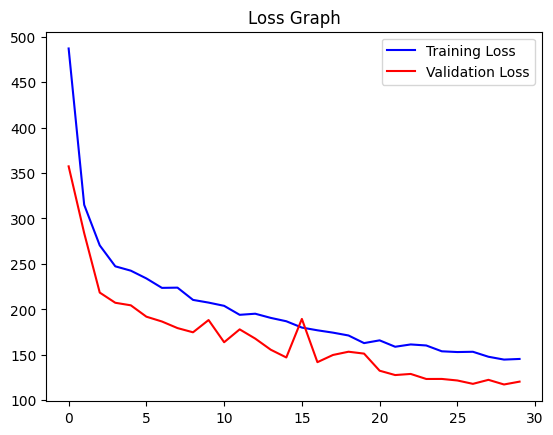

<Figure size 640x480 with 0 Axes>

In [38]:
# plot results for age
loss = history_age.history['loss']
val_loss = history_age.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

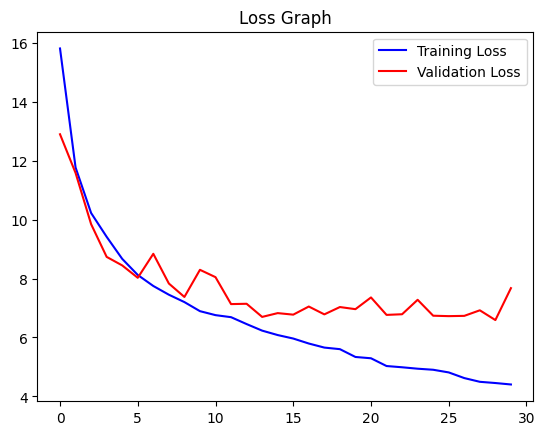

In [29]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

### Prediction with Test Data

In [45]:
image_index = np.random.randint(0, 400)
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 65
1/1 [==============================] - 0s 21ms/step


array([[52.44387]], dtype=float32)

Original Gender: Male Original Age: 44
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: 41


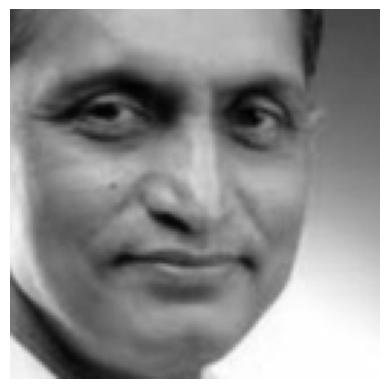

In [54]:
image_index = np.random.randint(0, 400)
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred1 = gender_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred1[0][0])]

pred2 = age_model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred2[0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

### Saving the Model

In [ ]:
# Save the model
#model.save('predictor.h5')  # Save in HDF5 format

# Loading the model to use for predictions
#loaded_model = tf.keras.models.load_model('my_model.h5')

### HyperParameter tuning 

In [56]:
import kerastuner as kt

In [57]:
def build_gender_model(hp):
    model = Sequential()
    
    input_shape = (128, 128, 1)
    #filters
    conv1_filter = hp.Int('conv1_filters', min_value=32, max_value=128, step=32)
    conv2_filter = hp.Int('conv2_filters', min_value=32, max_value=128, step=32)
    conv3_filter = hp.Int('conv3_filters', min_value=32, max_value=128, step=32)
    #for dense units
    dense_unit = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    #for optimizer learning rates
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(Conv2D(filters= conv1_filter, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(filters=conv2_filter, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(filters=conv3_filter, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=dense_unit, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

In [58]:
def build_age_model(hp):
    model = Sequential()
    
    input_shape = (128, 128, 1)
    #filters
    conv1_filter = hp.Int('conv1_filters', min_value=32, max_value=128, step=32)
    conv2_filter = hp.Int('conv2_filters', min_value=32, max_value=128, step=32)
    conv3_filter = hp.Int('conv3_filters', min_value=32, max_value=128, step=32)
    #for dense units
    dense_unit = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    #for optimizer learning rates
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(Conv2D(filters= conv1_filter, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(filters=conv2_filter, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(filters=conv3_filter, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=dense_unit, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model

In [60]:
tuner_gender = kt.Hyperband(
    build_gender_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='gender_classification'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 3, restore_best_weights=True)

tuner_gender.search(X_train, y_train_gender, epochs=10, validation_split = 0.2, callbacks = [stop_early])

Trial 30 Complete [00h 00m 51s]
val_accuracy: 0.5226673483848572

Best val_accuracy So Far: 0.9003689885139465
Total elapsed time: 00h 25m 22s


In [61]:
best_model_gender = tuner_gender.get_best_models(1)[0]
best_hp_gender = tuner_gender.get_best_hyperparameters(1)[0]

In [62]:
tuner_age = kt.Hyperband(
    build_age_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='age_regression'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 3, restore_best_weights=True)

tuner_age.search(X_train, y_train_age, epochs=10, validation_split = 0.2, callbacks = [stop_early] )

Trial 30 Complete [00h 01m 16s]
val_loss: 389.469970703125

Best val_loss So Far: 99.48307037353516
Total elapsed time: 00h 24m 52s


In [66]:
best_model_age = tuner_age.get_best_models(1)[0]
best_hp_age = tuner_age.get_best_hyperparameters(1)[0]

### Creating the final model with best hyperparameters

In [64]:
gender_model_final = tuner_gender.hypermodel.build(best_hp_gender)
hist_gender_final = gender_model_final.fit(X_train, y_train_gender, epochs = 30, validation_split = 0.2, callbacks = [stop_early])

Epoch 1/30
475/475 [==============================] - 9s 17ms/step - loss: 0.4511 - accuracy: 0.7816 - val_loss: 0.3376 - val_accuracy: 0.8392
Epoch 2/30
475/475 [==============================] - 7s 16ms/step - loss: 0.3330 - accuracy: 0.8537 - val_loss: 0.3021 - val_accuracy: 0.8645
Epoch 3/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2988 - accuracy: 0.8721 - val_loss: 0.2743 - val_accuracy: 0.8803
Epoch 4/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2706 - accuracy: 0.8843 - val_loss: 0.2611 - val_accuracy: 0.8859
Epoch 5/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2539 - accuracy: 0.8936 - val_loss: 0.2531 - val_accuracy: 0.8904
Epoch 6/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2297 - accuracy: 0.9030 - val_loss: 0.2681 - val_accuracy: 0.8880
Epoch 7/30
475/475 [==============================] - 7s 15ms/step - loss: 0.2151 - accuracy: 0.9100 - val_loss: 0.2410 - val_accuracy: 0.9041

In [67]:
age_model_final = tuner_age.hypermodel.build(best_hp_age)
hist_age_final = age_model_final.fit(X_train, y_train_age, epochs = 30, validation_split = 0.2, callbacks = [stop_early])

Epoch 1/30
475/475 [==============================] - 16s 33ms/step - loss: 455.6730 - val_loss: 331.5746
Epoch 2/30
475/475 [==============================] - 15s 32ms/step - loss: 276.8772 - val_loss: 207.0827
Epoch 3/30
475/475 [==============================] - 15s 32ms/step - loss: 218.5090 - val_loss: 203.1614
Epoch 4/30
475/475 [==============================] - 15s 31ms/step - loss: 191.7527 - val_loss: 163.0077
Epoch 5/30
475/475 [==============================] - 15s 31ms/step - loss: 171.0514 - val_loss: 137.9599
Epoch 6/30
475/475 [==============================] - 15s 31ms/step - loss: 151.5176 - val_loss: 119.2359
Epoch 7/30
475/475 [==============================] - 15s 31ms/step - loss: 140.6590 - val_loss: 119.5300
Epoch 8/30
475/475 [==============================] - 15s 31ms/step - loss: 133.9471 - val_loss: 106.5717
Epoch 9/30
475/475 [==============================] - 15s 31ms/step - loss: 127.9105 - val_loss: 103.3610
Epoch 10/30
475/475 [=========================